# Different Classification Models from ISLP

Below we will use preform different classificaiton methods using the Smakret dataset, which is loaded from the ISLP Package. The SMarket dataset contains daily percentage return for the S&P 500 stock index between 2001 and 2005. 

Below is information for each feature variables.

    Year: The year that the observation was recorded
    Lag1: Percentage return for previous day
    Lag2: Percentage return for 2 days previous
    Lag3: Percentage return for 3 days previous
    Lag4: Percentage return for 4 days previous
    Lag5: Percentage return for 5 days previous
    Volume: Volume of shares traded (number of daily shares traded in billions)
    Today: Percentage return for today

Here is the information for target variable.

    Direction: A factor with levels ‘Down’ and ‘Up’ indicating whether the market had a positive or negative return on a given day

For the full documentation on this dataset click on this link: [Smarket Dataset](https://islp.readthedocs.io/en/latest/datasets/Smarket.html)

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings

from ISLP import load_data

In [203]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA,
                                           QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

Let's start with importing the data from ISLP, and inspecting the data. We will also preform some pre-processing and split the data for analysis. Then let's create a logisitc regression classifier and examine some of the results. 

#### Pre-Processing the Data

In [183]:
# Loading the Dataset
Smarket = load_data('Smarket')

# Definine the features and target variables.
X = Smarket[Smarket.columns.drop(['Direction', 'Today', 'Year'])]
y = Smarket.Direction

# Define the split critera
train = Smarket.Year < 2005
test = ~train

# Train Test Split
X_train, y_train = X[train], y[train]
X_test, y_test = X[test], y[test]

# Make Sure the Data is Represented in Numerical Form
y_train = np.where(y_train == 'Up',0, 1)
y_test = np.where(y_test == 'Up',0 ,1)

# Function for feature standardization
def scaled_features(X:np.array, add_constant = False, data_library = 'sklearn') -> np.array:
    """ Returns a standardized np.array of features

    Args:
        X (np.array): Features
        add_constant (bool, optional): Add constant, which is needed for statsmodels. Defaults to False.
        output_format (str, optional): Must be sklearn or statsmodels, output the features as numpy array or 
            pandas dataframe depending on the model, and automaticall adds constant if data_libary == "statsmodel"

    Returns:
        np.array: Standardized features, scaled to zero mean and unit variance.
    """
    
    if not isinstance(data_library, str):
        raise TypeError(f'add_constant must be a bool. {add_constant} is not a valid input')
    
    if data_library not in ['sklearn', 'statsmodels']:
        warnings.warn(f'data_library not recognized. Must be "sklearn" or "statsmodels". Defaulting to "sklearn')
        output_format = 'statsmodels'
    
    X_columns = X.columns
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if add_constant:
        X_scaled = sm.add_constant(X_scaled)
        
    if data_library == "statsmodels":
        X_scaled = pd.DataFrame(X_scaled, columns = X_columns)
        X_scaled = sm.add_constant(X_scaled)
            
    return X_scaled

#### Logitic Regression Classifer

In [185]:
# Scikit Classifier
skl_classificaiton_model = LogisticRegression().fit(X_train, y_train)

# StatsModels Classifier
stm_classification_model = sm.GLM(y_train, scaled_features(X_train, data_library = "statsmodels"), family = sm.families.Binomial()).fit()

#### Evaluation

In [ ]:
# Explore Results fpr StatsModel Classifier
print(stm_classification_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  998
Model:                            GLM   Df Residuals:                      991
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -690.55
Date:                Sat, 21 Dec 2024   Deviance:                       1381.1
Time:                        13:10:52   Pearson chi2:                     998.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002162
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0321      0.063     -0.506      0.6

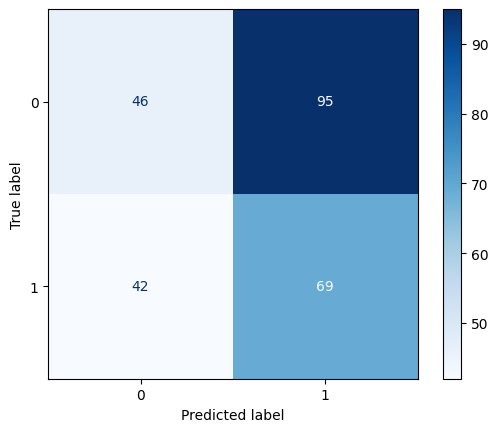

In [ ]:
# Predict Probabilities for the StatsModels Classifier
y_pred_prob = stm_classification_model.predict(scaled_features(X_test, data_library = "statsmodels"))

# Convert to Binary Labels
threshold = 0.5
y_preds = np.where(y_pred_prob > threshold, 0, 1)

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

# Display Confusion Matrix for StatsModel Classifer
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap = 'Blues')
plt.show()

In [214]:
accuracy = accuracy_score(y_test, y_preds)

print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.4563


Evaluating the data we can see that there is about 45% accuracy with logisitc regression. Meaning our model is less accurate than a coin flip. While expected we can certainly see that logistic regression on it's own is not a great model to start with. To continue to improve this let's look to collect some real data and create an autoregressive model.